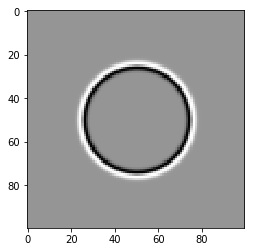

In [1]:
# necessary imports
import PIL.Image as Image
# plotting import
import pylab as py
# to show plots directly in the notebook
%matplotlib inline
import numpy as np

# first, create filters for scoring the presence of pupil in images
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def dog(x, center = 25, sig = 1):
    # difference of gaussians separated by 1 sigma
    # which is roughly the distance between the peaks
    return ( 
        gaussian(x,center+sig/2.0, sig) -
        gaussian(x, center-sig/2.0, sig) )
# let's look at a radial plot of this with the "center" at radius 25.
# could be a good filter for detecting pupils...
def ringed_dog_filter(dog_filter, center=(50,50), 
                      radius=25):
    # note, this changes the passed dog_filter
    size = dog_filter.shape
    dog_filter *= 0
    # x and y are both the indices and the values used
    for x in range(0,size[0]):
        for y in range(0,size[1]):
            r = np.sqrt( (x-center[0])**2 + (y-center[1])**2 )
            dog_filter[x,y] = dog(r, center=radius, sig=1)
    # normalize the mean and standard deviation
    #dog_filter -= np.mean(dog_filter)
    # dog_filter /= np.std(dog_filter)
    # and to assure the strength is proportional to the radius
    dog_filter /= radius  # not sure about this

img = np.zeros((100,100));
ringed_dog_filter(img)
py.imshow(img, cmap=py.cm.Greys_r)

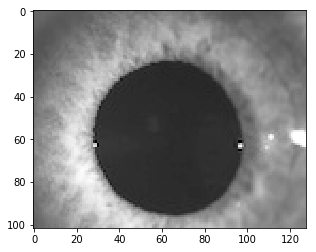

In [66]:
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)

img = get_image_mat('frame60_Small.jpg')
show_image(img)

In [67]:
def filter_score(img, dog_filter, center, radius):
    # use a ringed dog filter on the image
    ringed_dog_filter(dog_filter, center, radius)
    return np.sum(np.multiply(dog_filter, img))

def add_circle(img_mat,center,radius,luminance):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in np.arange(-0.2,0.2, 0.1): # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat[x,y] = luminance
    return

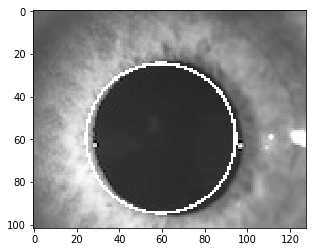

In [68]:
# let's have center and size that are slightly off and fix it
wrong_center = (60,60) # might have some error
wrong_radius = 35 

show_circle_img = img.copy()
add_circle(show_circle_img,wrong_center,wrong_radius,255)
show_image(show_circle_img)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -413.29990617151174
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
(63.34193304393345, 59.579655543189524) 36.15841995112023


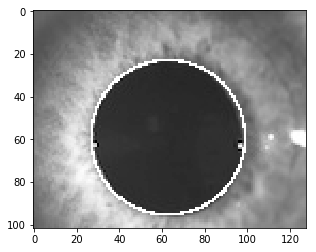

In [69]:
from scipy.optimize import minimize

def optimize_pupil_fit_SLSQP(img, center, radius, step=1.0, max_range=3.0):
    cx = center[0]
    cy = center[1]
    r = radius
    dog_filter = np.zeros(img.shape)
    
    def filter_score2(x):
        score = filter_score(img, dog_filter, center=(x[0],x[1]), radius=x[2])
        return -score
    
    x0 = ([cx,cy,r])
    bounds = ((50, 70), (50, 70), (30, 50))
    res = minimize(filter_score2, x0, method='SLSQP', options={'disp': True}, bounds=bounds)
    return (res.x)

(max_center_x, max_center_y, max_radius) = optimize_pupil_fit_SLSQP(img, wrong_center, wrong_radius)
max_center = (max_center_x, max_center_y)
print(max_center, max_radius)
show_circle_img = img.copy()
add_circle(show_circle_img,max_center,max_radius,255)
show_image(show_circle_img)

In [70]:
def optimize_pupil_fit_LBFGSB(img, center, radius, step=1.0, max_range=3.0):
    cx = center[0]
    cy = center[1]
    r = radius
    dog_filter = np.zeros(img.shape)
    
    def filter_score2(x):
        score = filter_score(img, dog_filter, center=(x[0],x[1]), radius=x[2])
        return -score
    
    x0 = ([cx,cy,r])
    bounds = ((50, 70), (50, 70), (30, 50))
    res = minimize(filter_score2, x0, method='L-BFGS-B', options={'disp': True}, bounds=bounds)
    return (res.x)

def optimize_pupil_fit_Nelder_Mead(img, center, radius, step=1.0, max_range=3.0):
    cx = center[0]
    cy = center[1]
    r = radius
    dog_filter = np.zeros(img.shape)
    
    def filter_score2(x):
        score = filter_score(img, dog_filter, center=(x[0],x[1]), radius=x[2])
        return -score
    
    x0 = ([cx,cy,r])
    res = minimize(filter_score2, x0, method='Nelder-Mead', options={'disp': True})
    return (res.x)

In [71]:
import timeit
print(timeit.timeit("optimize_pupil_fit_SLSQP(img, wrong_center, wrong_radius)", globals=globals(), number=1))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -413.29990617151174
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
12.987292606965639


In [72]:
print(timeit.timeit("optimize_pupil_fit_LBFGSB(img, wrong_center, wrong_radius)", globals=globals(), number=1))

11.695981893921271


In [73]:
print(timeit.timeit("optimize_pupil_fit_Nelder_Mead(img, wrong_center, wrong_radius)", globals=globals(), number=1))

Optimization terminated successfully.
         Current function value: -413.299906
         Iterations: 59
         Function evaluations: 111
20.19357734604273
